<a href="https://colab.research.google.com/github/VishalIITP/FaceMaskDetection/blob/main/FaceMaskDetetction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "/content/drive/MyDrive/Collab/FaceMaskDetection/DataSet/Medical mask/annotations"
image_directory = "/content/drive/MyDrive/Collab/FaceMaskDetection/DataSet/Medical mask/images"
df1 = pd.read_csv("/content/drive/MyDrive/Collab/FaceMaskDetection/DataSet/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Collab/FaceMaskDetection/DataSet/submission.csv")

In [56]:
df=df1
df=df.sort_values('name')
df=df[0:1167]

In [57]:
cvNet = cv2.dnn.readNetFromCaffe('/content/drive/MyDrive/Collab/FaceMaskDetection/DataSet/Medical mask/deploy.prototxt','/content/drive/MyDrive/Collab/FaceMaskDetection/DataSet/Medical mask/weights.caffemodel')
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [58]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '1822.jpg',
 'NumOfAnno': 3,
 'Annotations': [{'isProtected': False,
   'ID': 260640944262196864,
   'BoundingBox': [510, 2, 708, 213],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 667730727560255488,
   'BoundingBox': [521, 89, 679, 200],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 811180985565330688,
   'BoundingBox': [518, 1, 718, 50],
   'classname': 'hair_net',
   'Confidence': 1,
   'Attributes': {}}]}

In [59]:
df.head()

,name,x1,x2,y1,y2,classname
13381,1801.jpg,451,186,895,697,face_no_mask
3464,1802.jpg,160,151,268,265,mask_surgical
3463,1802.jpg,110,71,273,272,face_with_mask
14836,1803.jpg,147,200,288,320,mask_surgical
14835,1803.jpg,126,75,303,333,face_with_mask


In [60]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["without mask"]])
random.shuffle(data)




In [61]:
data[0][1]

0

<Axes: ylabel='count'>

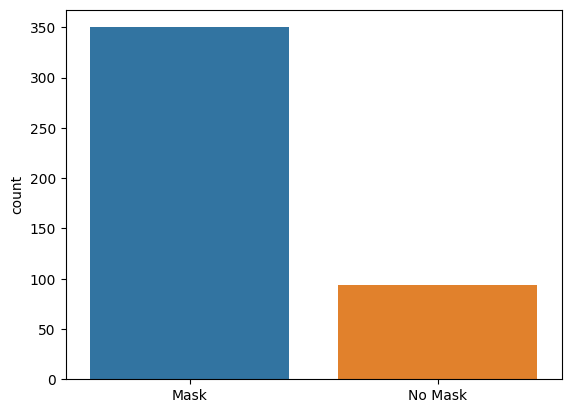

In [62]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(x=p)

In [63]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [37]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(124, 124, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
xtrain, xval, ytrain, yval = train_test_split(X, Y, train_size=0.8, random_state=0)

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(xtrain)

history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                              steps_per_epoch=xtrain.shape[0] // 32,
                              epochs=50,
                              verbose=1,
                              validation_data=(xval, yval))


<ipython-input-37-d37ab01d6b9b>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),


Epoch 1/50
11/11 [==============================] - 92s 8s/step - loss: 1.1306 - accuracy: 0.7028 - val_loss: 0.4472 - val_accuracy: 0.7753
Epoch 2/50
11/11 [==============================] - 90s 8s/step - loss: 0.3445 - accuracy: 0.7988 - val_loss: 0.4117 - val_accuracy: 0.8652
Epoch 3/50
11/11 [==============================] - 90s 8s/step - loss: 0.2945 - accuracy: 0.8483 - val_loss: 0.3428 - val_accuracy: 0.8427
Epoch 4/50
11/11 [==============================] - 87s 8s/step - loss: 0.2576 - accuracy: 0.8731 - val_loss: 0.4185 - val_accuracy: 0.8315
Epoch 5/50
11/11 [==============================] - 84s 8s/step - loss: 0.2972 - accuracy: 0.9102 - val_loss: 0.3014 - val_accuracy: 0.8539
Epoch 6/50
11/11 [==============================] - 97s 9s/step - loss: 0.2348 - accuracy: 0.9062 - val_loss: 0.2805 - val_accuracy: 0.8652
Epoch 7/50
11/11 [==============================] - 87s 9s/step - loss: 0.2557 - accuracy: 0.9226 - val_loss: 0.2707 - val_accuracy: 0.8764
Epoch 8/50
11/11 [==

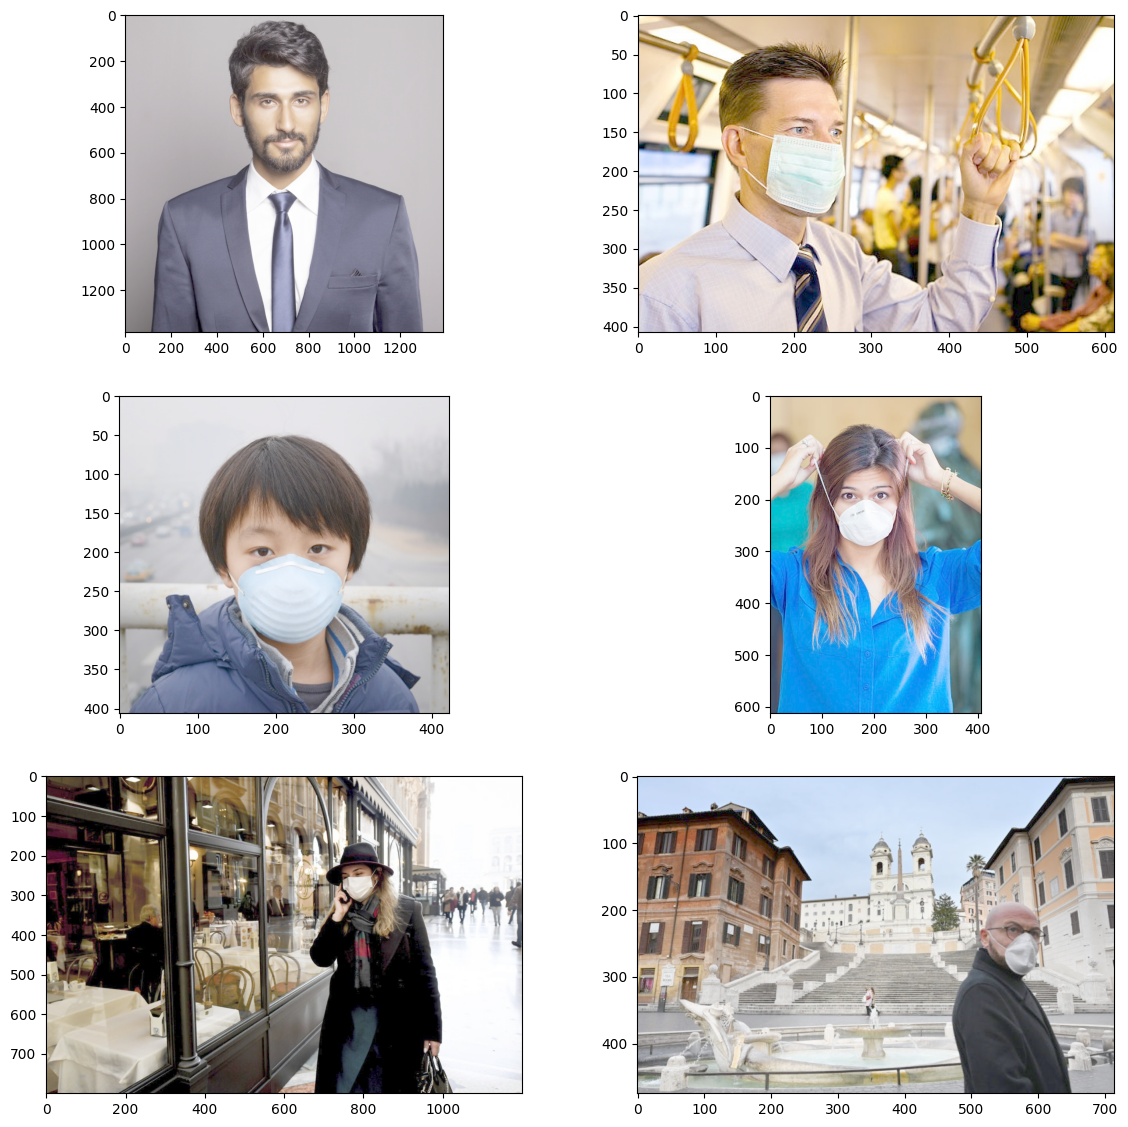

In [69]:
test_images = ['1801.jpg','1802.jpg', '1803.jpg','1804.jpg','1805.jpg','1806.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)

        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()